# Introduction to pycox

### quick start

We here give introduction to simple models in the pycox framework.
This is the simples way to use the package, but not very configurable.

**See other examples for more recommended usage.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

In [2]:
from pycox.models.cox import CoxPH, CoxTime
from pycox.models.high_level import CoxPHLinear, CoxTimeReluNet, CoxPHReluNet
import pycox.simulations as sims

# Simulations

We create a simulated dataset withe survival times as function of 3 covariates.

See paper (ref pycox paper) if you want to understand the details.

In [3]:
np.random.seed(1234)

In [4]:
h0 = 0.01 # baseline hazard
max_duration = 30. # Censor durateions larger than 30
c0 = 30. # Cencoring distribution
sim = sims.NonLinearNonPH(h0, max_duration, c0)

In [5]:
n_tr = 10000 # Training samples
n_val = 1000 # Validation samples
n_te = 1000 # Testing samples

In [6]:
Xtr, t_tr, e_tr = sim.simulate(n_tr) # [X, times, event indicators]
Xval, t_val, e_val = sim.simulate(n_val) 
Xte, t_te, e_te = sim.simulate(n_te) 

In [7]:
def make_df(X, t, e):
    return (pd.DataFrame(X, columns=['x0', 'x1', 'x2'])
            .assign(time=t, event=e))

In [8]:
train = make_df(Xtr, t_tr, e_tr)
val = make_df(Xval, t_val, e_val)
test = make_df(Xte, t_te, e_te)

In [9]:
train.head()

,x0,x1,x2,time,event
0,-0.616961,0.244218,-0.124545,26.736973,True
1,0.570717,0.559952,-0.454815,6.738238,False
2,-0.447071,0.603744,0.916279,2.584234,True
3,0.751865,-0.284365,0.001990,1.086528,True
4,0.366926,0.425404,-0.259498,0.897150,False


## Features scaling

Covariates needs to be standardized. 
We use the DataFrame mapper from sklearn_pandas, but you are free to scale them however you want.

Here we also scale time (with MapperCoxTime), this is only necessary for the Cox-Time models, and does not affect the Cox models with proportional hazards.

In [10]:
from pycox.utils.utils import MapperCoxTime
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

In [11]:
stdscale_cols = [([col], StandardScaler()) for col in train.columns.drop(['time', 'event'])]
cov_mapper = DataFrameMapper(stdscale_cols)
mapper = MapperCoxTime(cov_mapper, 'time', 'event')

In [12]:
df_train = mapper.fit_transform(train)
df_val = mapper.transform(val)
df_test = mapper.transform(test)

In [13]:
df_train.head()

,x0,x1,x2,time,event
0,-1.053298,0.416397,-0.217522,1.814168,True
1,0.987328,0.959894,-0.791162,-0.425662,False
2,-0.761399,1.035278,1.590262,-0.890904,True
3,1.298570,-0.493493,0.002253,-1.058645,True
4,0.637181,0.728287,-0.451921,-1.079855,False


# Cox-SGD

Regular proportional Cox regression, with linear $g(x)$ .

$h(t, x) = h_0(t) \exp[g(x)]$

In [14]:
input_size = df_train.drop(['time', 'event'], axis=1).shape[1]

In [15]:
cox_sgd = CoxPHLinear(input_size)

In [16]:
%%time
log = cox_sgd.fit(df_train, 'time', 'event', epochs=100, verbose=False)

CPU times: user 8.37 s, sys: 302 ms, total: 8.67 s
Wall time: 9.75 s


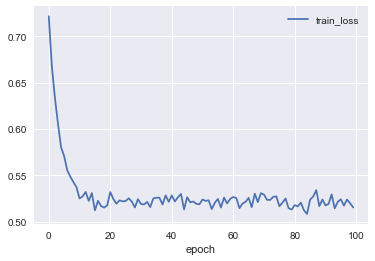

In [17]:
_ = log.to_pandas().plot()

In [18]:
cox_sgd.concordance_index(df_test) # A common evaluation measures for proportional models.

0.7959998588789213

# Cox-MLP

Regular proportional Cox regression, but where $g(x)$ is an MLP.

$h(t, x) = h_0(t) \exp[g(x)]$

We let the MLP have ReLU acitaatoins, 2 hidden layers, with 32 nodes in each layer, and batch norm between layers.

In [19]:
cox_mlp = CoxPHReluNet(input_size, n_layers=2, n_nodes=32, dropout=False, batch_norm=True)

In [20]:
cox_mlp.g

ReluNet(
  (net): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Linear(in_features=3, out_features=32, bias=True)
        (1): ReLU()
      )
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
      )
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)

In [21]:
log = cox_mlp.fit(df_train, 'time', 'event', df_val=df_val, epochs=10, verbose=True)

Epoch: 0,	time: 0 sec,	train_loss: 0.5359,	val_loss: 0.4527
Epoch: 1,	time: 0 sec,	train_loss: 0.4527,	val_loss: 0.4330
Epoch: 2,	time: 0 sec,	train_loss: 0.4338,	val_loss: 0.4172
Epoch: 3,	time: 0 sec,	train_loss: 0.4234,	val_loss: 0.3957
Epoch: 4,	time: 0 sec,	train_loss: 0.4206,	val_loss: 0.4008
Epoch: 5,	time: 0 sec,	train_loss: 0.4085,	val_loss: 0.4082
Epoch: 6,	time: 0 sec,	train_loss: 0.4150,	val_loss: 0.3859
Epoch: 7,	time: 0 sec,	train_loss: 0.4014,	val_loss: 0.3979
Epoch: 8,	time: 0 sec,	train_loss: 0.4064,	val_loss: 0.3877
Epoch: 9,	time: 0 sec,	train_loss: 0.4056,	val_loss: 0.3969


### Alternatively

We set:

 - Device to run on (gpu or cpu).
 - Optimizer.
 - Store weights of best model (in val_loss) to file.

In [22]:
import torch

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer_func = lambda x: torch.optim.Adam(x)
cox_mlp = CoxPHReluNet(input_size, n_layers=2, n_nodes=32, dropout=False, batch_norm=True,
                       optimizer_func=optimizer_func, device=device)

In [24]:
%%time
log = cox_mlp.fit(df_train, 'time', 'event', df_val=df_val, batch_size=128, epochs=100, verbose=False,
                  model_path='cox_mlp.torch')

CPU times: user 40.6 s, sys: 1.71 s, total: 42.3 s
Wall time: 18.5 s


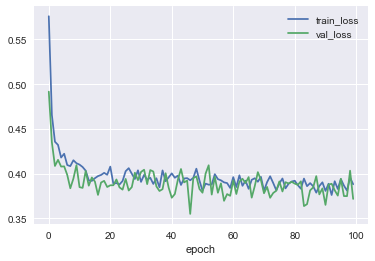

In [25]:
_ = log.to_pandas().plot()

In [26]:
cox_mlp.concordance_index(df_test)

0.8511525422641595

#### Load best model
To retreive the model, we need to recalculate the baseline.

In [27]:
cox_mlp.load_model_weights('cox_mlp.torch')
_ = cox_mlp.compute_baseline_hazards()

/Users/havard/packages/pycox/pycox/models/cox.py:282: UserWarning: Might need to transfer to cuda???
  warnings.warn('Might need to transfer to cuda???')
/Users/havard/packages/pycox/pycox/models/cox.py:283: UserWarning: Need to recompute baseline hazards after loading.
  warnings.warn('Need to recompute baseline hazards after loading.')
/Users/havard/packages/pycox/pycox/models/cox.py:284: UserWarning: Might need to set optim again!
  warnings.warn('Might need to set optim again!')


In [28]:
cox_mlp.concordance_index(df_test)

0.8479260012380168

### Plot survival curves


In [29]:
sub = df_test.sample(6)

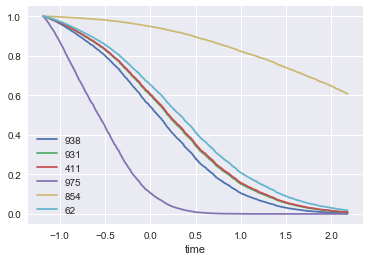

In [30]:
surv_preds = cox_mlp.predict_survival_function(sub)
_ = surv_preds.plot()

If we have scaled the time (which is only necessary for the CoxTime models), we can compute the inverse scaling.

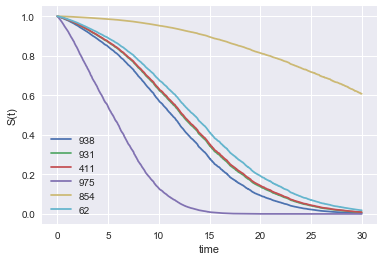

In [31]:
orig_scale = mapper.inverse_duration(surv_preds.index)
surv_preds = surv_preds.set_index(orig_scale)
surv_preds.plot()
plt.ylabel('S(t)')
_ = plt.xlabel('time')

# Cox-Time

We repeat everyting with the Cox-Time model.

This model has no longer proportional hazards, but a time dependent $g(x, t)$.

$h(t, x) = h_0(t) \exp[g(x, t)]$

We need larger inputsize size time is noe a covariate.

In [32]:
input_size_time = input_size + 1

In [33]:
cox_time = CoxTimeReluNet(input_size_time, n_layers=2, n_nodes=32, dropout=False, batch_norm=True,
                          optimizer_func=optimizer_func, device=device)

In [34]:
%%time
log = cox_time.fit(df_train, 'time', 'event', df_val=df_val, batch_size=128, epochs=100, verbose=False,
                  model_path='cox_time.torch')

CPU times: user 50.1 s, sys: 1.65 s, total: 51.8 s
Wall time: 20.5 s


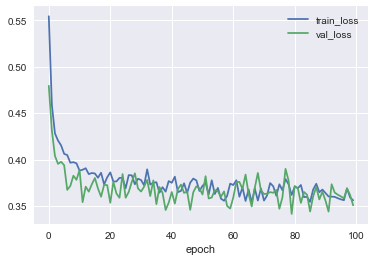

In [35]:
_ = log.to_pandas().plot()

### Comparing val_loss with Cox-MLP

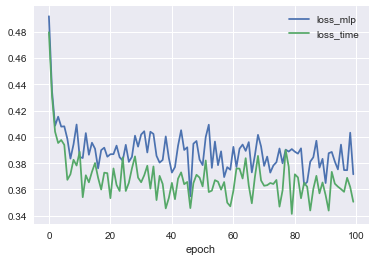

In [36]:
(cox_mlp.val_loss.to_pandas()
 .join(cox_time.val_loss.to_pandas(), how='outer', lsuffix='_mlp', rsuffix='_time')
 .plot())
None

#### Load best model

When calculating the baseline, we suggest that we only use a sample of the trainingset. If not, it will be very computational.

In [37]:
%%time
cox_time.load_model_weights('cox_time.torch')
_ = cox_time.compute_baseline_hazards(sample=3000)

/Users/havard/packages/pycox/pycox/models/cox.py:282: UserWarning: Might need to transfer to cuda???
  warnings.warn('Might need to transfer to cuda???')
/Users/havard/packages/pycox/pycox/models/cox.py:283: UserWarning: Need to recompute baseline hazards after loading.
  warnings.warn('Need to recompute baseline hazards after loading.')
/Users/havard/packages/pycox/pycox/models/cox.py:284: UserWarning: Might need to set optim again!
  warnings.warn('Might need to set optim again!')


CPU times: user 15.1 s, sys: 338 ms, total: 15.4 s
Wall time: 9.4 s


### Plot survival curves

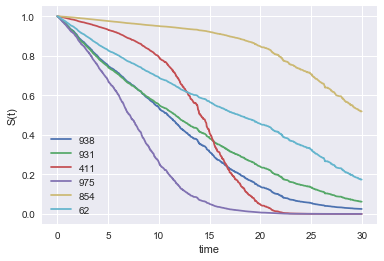

In [38]:
surv_preds_time = cox_time.predict_survival_function(sub)
orig_scale = mapper.inverse_duration(surv_preds_time.index)
surv_preds_time = surv_preds_time.set_index(orig_scale)
surv_preds_time.plot()
plt.ylabel('S(t)')
_ = plt.xlabel('time')

# Get binary predictions

We now create a binary dataset at time 15.
Hence, we label events prior to 15 as True, and events after 15 as False.

We also need to remove individuals censored before time 15.

In [39]:
time = 15.
t_time = mapper.transform_duration(time).values[0] # Transformed time

#### Create a dataset with labels, and censored individuals are removed

In [40]:
df_test_15 = (df_test
              .assign(label=lambda x: x['time'] < t_time)
              .assign(cencored=lambda x: x['label'] & (x['event'] == False))
              .loc[lambda x: x['cencored']==False]
              .drop('cencored', axis=1)
             )

In [41]:
df_test_15.head()

,x0,x1,x2,time,event,label
0,-1.129855,-0.238335,0.671148,-0.873787,True,True
1,-0.994923,1.279075,0.291688,0.237740,True,True
2,0.900324,0.339402,1.121731,-0.403527,True,True
4,-0.051453,-1.037720,-1.546872,2.179623,False,False
5,0.930539,-1.288672,-1.324549,-0.496309,True,True


#### Get predictions

In [42]:
%%time
surv_15 = cox_time.predict_survival_at_times(t_time, df_test_15)

CPU times: user 13.7 s, sys: 360 ms, total: 14 s
Wall time: 9.45 s


In [43]:
preds = 1 - surv_15.values.flatten()
true = df_test_15['label'].values

#### Get accuracy and ROC AUC

In [44]:
from sklearn import metrics

In [45]:
metrics.accuracy_score(true, preds > 0.5)

0.8679504814305364

In [46]:
metrics.roc_auc_score(true, preds)

0.9398228286325221

### ... and for Cox-MLP

In [47]:
%%time
surv_15 = cox_mlp.predict_survival_at_times(t_time, df_test_15)

CPU times: user 7.42 ms, sys: 319 µs, total: 7.74 ms
Wall time: 4.14 ms


In [48]:
preds = 1 - surv_15.values.flatten()

In [49]:
metrics.accuracy_score(true, preds > 0.5)

0.8775790921595599

In [50]:
metrics.roc_auc_score(true, preds)

0.9406289244136713

### ... and for Cox-SGD

In [51]:
%%time
surv_15 = cox_sgd.predict_survival_at_times(t_time, df_test_15)

CPU times: user 7.09 ms, sys: 1.65 ms, total: 8.74 ms
Wall time: 5.11 ms


In [52]:
preds = 1 - surv_15.values.flatten()

In [53]:
metrics.accuracy_score(true, preds > 0.5)

0.797799174690509

In [54]:
metrics.roc_auc_score(true, preds)

0.8615127447985611